In [10]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay


In [11]:
# Load the Titanic dataset
df = pd.read_csv("/content/COMP1816_Titanic_Dataset_Classification.csv")

# Display basic info
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890 entries, 0 to 889
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  890 non-null    int64  
 1   Pclass       880 non-null    float64
 2   Name         885 non-null    object 
 3   Sex          890 non-null    object 
 4   Age          715 non-null    float64
 5   SibSp        888 non-null    float64
 6   Parch        888 non-null    float64
 7   Ticket No.   888 non-null    object 
 8   Fare         888 non-null    float64
 9   Embarked     884 non-null    object 
 10  Survival     886 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 76.6+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket No.,Fare,Embarked,Survival
0,1,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,S,0.0
1,2,1.0,NaN,female,38.0,1.0,0.0,PC 17599,71.2833,C,1.0
2,3,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,S,1.0
3,4,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,S,1.0
4,5,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,S,0.0


In [12]:
# Check missing values before handling
print("Missing values before handling:\n", df.isnull().sum())

# Define numerical and categorical columns
num_cols = ["Age", "Fare", "Pclass", "SibSp", "Parch"]
cat_cols = ["Sex", "Embarked"]

# Fill missing numerical values with median
imputer = SimpleImputer(strategy="median")
df[num_cols] = imputer.fit_transform(df[num_cols])

# Fill missing categorical values with mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Drop rows where "Survival" is missing (since it's the target variable)
df = df.dropna(subset=["Survival"])

# Drop "Name" and "Ticket No." if they exist
df.drop(columns=["Name", "Ticket No."], inplace=True, errors="ignore")

# Verify missing values handled
print("Missing values after handling:\n", df.isnull().sum())


Missing values before handling:
 PassengerId      0
Pclass          10
Name             5
Sex              0
Age            175
SibSp            2
Parch            2
Ticket No.       2
Fare             2
Embarked         6
Survival         4
dtype: int64
Missing values after handling:
 PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Survival       0
dtype: int64


<ipython-input-12-54e00fc1cbfd>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Name", "Ticket No."], inplace=True, errors="ignore")


In [13]:
# Encode categorical features
encoder = LabelEncoder()
df["Sex"] = encoder.fit_transform(df["Sex"])  # Male = 1, Female = 0
df["Embarked"] = encoder.fit_transform(df["Embarked"])  # Convert C, Q, S to numerical values

# Display transformed dataset
df.head()


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survival
0,1,3.0,1,22.0,1.0,0.0,7.2500,2,0.0
1,2,1.0,0,38.0,1.0,0.0,71.2833,0,1.0
2,3,3.0,0,26.0,0.0,0.0,7.9250,2,1.0
3,4,1.0,0,35.0,1.0,0.0,53.1000,2,1.0
4,5,3.0,1,35.0,0.0,0.0,8.0500,2,0.0


In [14]:
# Define features (X) and target (y)
X = df.drop("Survival", axis=1)
y = df["Survival"]

# Use the last 140 data points for testing (before shuffling)
X_train, X_test = X[:-140], X[-140:]
y_train, y_test = y[:-140], y[-140:]

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (746, 8), Testing set: (140, 8)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
svm_param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.1, 1],
    "kernel": ["rbf", "linear", "poly"]
}

svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring="f1", n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = svm_grid.best_estimator_
print("Best SVM Parameters:", svm_grid.best_params_)


Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [17]:
# Use the best SVM model from GridSearchCV
svm_model = best_svm  # Assign the best model from tuning

# Train the best SVM model
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("Optimized SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))



Optimized SVM Accuracy: 0.8214285714285714
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87        90
         1.0       0.79      0.68      0.73        50

    accuracy                           0.82       140
   macro avg       0.81      0.79      0.80       140
weighted avg       0.82      0.82      0.82       140



In [18]:
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring="f1", n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best RF model
best_rf = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [19]:
# Use the best Random Forest model from GridSearchCV
rf_model = best_rf  # Assign the best model from tuning

# Train the best Random Forest model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Optimized Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



Optimized Random Forest Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88        90
         1.0       0.78      0.80      0.79        50

    accuracy                           0.85       140
   macro avg       0.84      0.84      0.84       140
weighted avg       0.85      0.85      0.85       140



In [20]:
# Define parameter grid for KNN
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring="f1", n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

# Best KNN model
best_knn = knn_grid.best_estimator_
print("Best KNN Parameters:", knn_grid.best_params_)


Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [21]:
# Use the best KNN model from GridSearchCV
knn_model = best_knn  # Assign the best model from tuning

# Train the best KNN model
knn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluation
print("Optimized KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


Optimized KNN Accuracy: 0.8
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        90
         1.0       0.70      0.78      0.74        50

    accuracy                           0.80       140
   macro avg       0.78      0.80      0.79       140
weighted avg       0.81      0.80      0.80       140



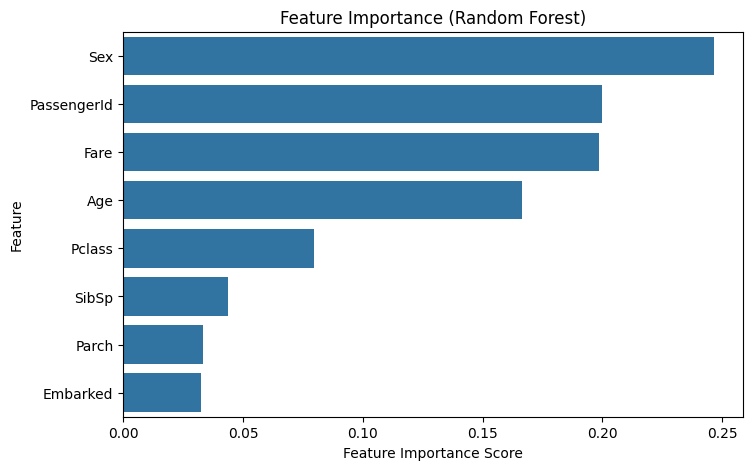

In [22]:
# Get feature importances from Random Forest
feature_importances = best_rf.feature_importances_

# Create a DataFrame to display feature importance
feature_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_df["Importance"], y=feature_df["Feature"])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.show()


In [23]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions from each optimized model
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test)
y_pred_knn = best_knn.predict(X_test_scaled)

# Compute Accuracy, Precision, Recall, and F1-score for all models
models = ["SVM", "Random Forest", "KNN"]
accuracy = [
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_knn),
]
precision = [
    precision_score(y_test, y_pred_svm),
    precision_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_knn),
]
recall = [
    recall_score(y_test, y_pred_svm),
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_knn),
]
f1 = [
    f1_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_knn),
]

# Store results in a DataFrame
model_comparison_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})


# Display the results
from IPython.display import display
display(model_comparison_df)


,Model,Accuracy,Precision,Recall,F1-Score
0,SVM,0.821429,0.790698,0.68,0.731183
1,Random Forest,0.850000,0.784314,0.80,0.792079
2,KNN,0.800000,0.696429,0.78,0.735849


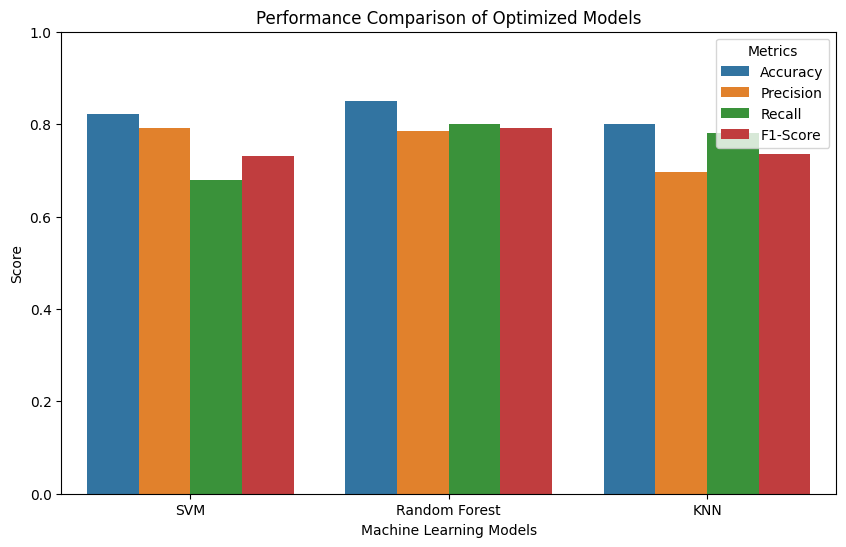

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 6))

# Melt dataframe for easier plotting
model_comparison_melted = model_comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot bar chart
sns.barplot(x="Model", y="Score", hue="Metric", data=model_comparison_melted)

# Customize plot
plt.xlabel("Machine Learning Models")
plt.ylabel("Score")
plt.title("Performance Comparison of Optimized Models")
plt.ylim(0, 1)  # Set score range from 0 to 1
plt.legend(title="Metrics")

# Show plot
plt.show()


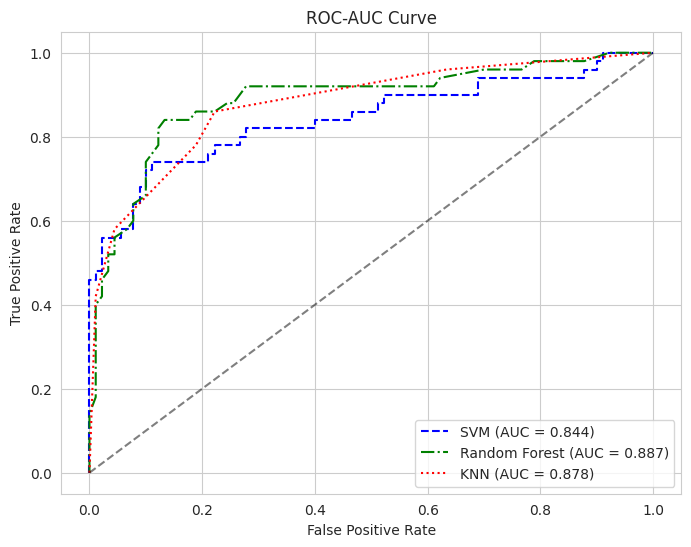

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Ensure models support probability prediction
if not hasattr(best_svm, "predict_proba"):
    print("Warning: SVM does not support predict_proba. Using decision_function instead.")
    svm_probs = best_svm.decision_function(X_test_scaled)  # Alternative to predict_proba
else:
    svm_probs = best_svm.predict_proba(X_test_scaled)[:, 1]

rf_probs = best_rf.predict_proba(X_test)[:, 1]
knn_probs = best_knn.predict_proba(X_test_scaled)[:, 1]

# Compute ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)

# Compute AUC scores
auc_svm = auc(fpr_svm, tpr_svm)
auc_rf = auc(fpr_rf, tpr_rf)
auc_knn = auc(fpr_knn, tpr_knn)

# Improve plot styling
sns.set_style("whitegrid")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})", linestyle="--", color="blue")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linestyle="-.", color="green")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.3f})", linestyle=":", color="red")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)  # Diagonal line

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


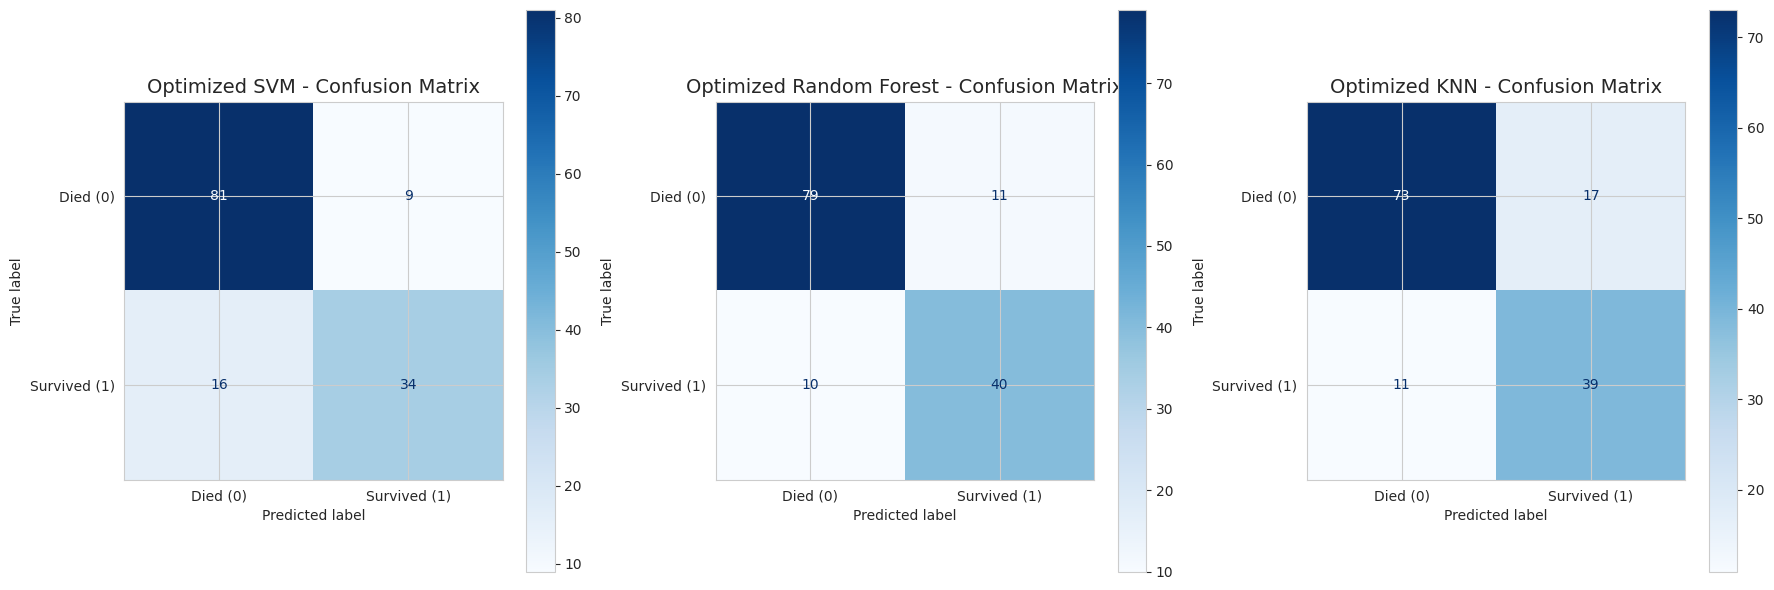

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices for optimized models
cm_svm = confusion_matrix(y_test, best_svm.predict(X_test_scaled))
cm_rf = confusion_matrix(y_test, best_rf.predict(X_test))
cm_knn = confusion_matrix(y_test, best_knn.predict(X_test_scaled))

# Improve plot styling
sns.set_style("whitegrid")

# Create subplots for 3 confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# SVM Confusion Matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=["Died (0)", "Survived (1)"])
disp_svm.plot(ax=axes[0], cmap="Blues", values_format="d")  # "d" ensures integer display
axes[0].set_title("Optimized SVM - Confusion Matrix", fontsize=14)

# Random Forest Confusion Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Died (0)", "Survived (1)"])
disp_rf.plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title("Optimized Random Forest - Confusion Matrix", fontsize=14)

# KNN Confusion Matrix
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=["Died (0)", "Survived (1)"])
disp_knn.plot(ax=axes[2], cmap="Blues", values_format="d")
axes[2].set_title("Optimized KNN - Confusion Matrix", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

